# ニ値分類問題
1. titanicデータを使用 [kaggle](https://www.kaggle.com/c/titanic/data)
3. 分類器はロジスティック回帰、SVM、GBDTを試す。
   - それぞれハイパラをCVで決定し、アルゴリズムの対決をtestデータの AUCスコアで評価する

## 下準備

In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [245]:
sns.set_theme()

In [312]:
data = pd.read_csv('./dump/titanic/train.csv')
data = data.set_index('PassengerId',drop=True)

### データを眺める
#### 欠損確認

In [313]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Age、Cabin、Embarkedに欠損がある  
Pclassはカテゴリカルだが順序尺度なのでとりあえずこのまま使う？

### 分割

In [314]:
y = np.array(data.Survived)
feature_names = list(data.columns)[1:]
X = np.array(data[feature_names])
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X,y,random_state=42)

In [315]:
data = pd.DataFrame(X_trainval)
data = data.rename(columns=dict(zip(range(len(feature_names)),feature_names)))
data['Survived'] = y_trainval

### Pclass

In [280]:
data.groupby('Pclass').count()

,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
Pclass,,,,,,,,,,
1,152,152,133,152,152,152,152,126,150,152
2,141,141,131,141,141,141,141,12,141,141
3,375,375,272,375,375,375,375,11,375,375


In [283]:
data.groupby('Pclass').sum(
    # numeric_only=True
    )


,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
Pclass,,,,,,,,,,
1,"Saalfeld, Mr. AdolpheAllison, Master. Hudson T...",malemalefemalefemalefemalemalemalefemalefemale...,5066.92,67,52,19988113781PC 17608113572PC 17757113786PC 1761...,13352.9125,C106C22 C26B57 B59 B63 B66B28C104D11C86E38C52A...,SSCCSSSSCSSSSSCSSCCSSSSSCCCSSSCSCSCCCCSSSCCSCS...,93
2,"Hamalainen, Mrs. William (Anna)Kantor, Mrs. Si...",femalefemalemalemalefemalemalemalefemalefemale...,3916.0,60,54,25064924436728664219533SC/AH 3085230080C.A. 17...,2906.7209,F2F2DF2F33F4E101E101E101F4F33D56,SSSQSSSSSSSSCSCSCSSSSCSSSSSSSSSSSCSCSSSSSCSSCS...,68
3,"Sutehall, Mr. Henry JrKarlsson, Mr. Nils Augus...",malemalefemalemalefemalemalefemalefemalemalema...,6786.92,243,143,SOTON/OQ 392076350060STON/O2. 3101282384461262...,5236.2036,F G73G6E10F G73E121E121F E69G6G6F38F G63,SSSQCSSSSCSCSSSSSQCSSSSSSSSSSSSQSSSQCCSQCSSSSS...,92


人数的にも対応的にも等間隔はちょっとビミョいのでダミー変数にする

#### SibSpとParchについて

In [285]:
print('SibSp',set(data.SibSp))
print('Parch',set(data.Parch))

SibSp {0, 1, 2, 3, 4, 5, 8}
Parch {0, 1, 2, 3, 4, 5, 6}


In [286]:
data.loc[data.Parch==6]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
131,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9,NaN,S,0


In [287]:
data.loc[data.SibSp==8]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
188,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,0
300,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,0
324,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,0
451,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,0
480,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,0
499,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,0
578,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,0


SibSp=8, Parch=2の一家は7人しか名前がなかったり、Parch=6の人は1人しかいないのはtrain_test_splitのため  

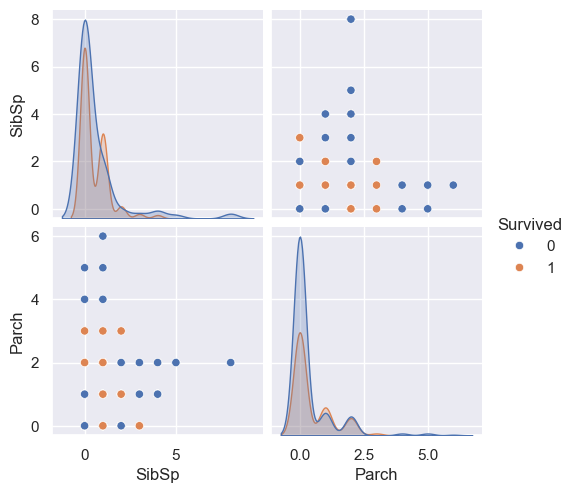

In [289]:
sns.pairplot(
    data[['Survived','SibSp','Parch']],
    hue='Survived'
)

In [290]:
data[['Survived','SibSp','Parch']].corr()

,Survived,SibSp,Parch
Survived,1.000000,-0.042042,0.076448
SibSp,-0.042042,1.000000,0.438936
Parch,0.076448,0.438936,1.000000


In [291]:
test=data[['Survived','SibSp','Parch']].copy()

def trans(x):
    if x==0:
        return x
    else:
        return 1

test['SibSp']=test.SibSp.apply(trans)
test['Parch']=test.Parch.apply(trans)
test.corr()


,Survived,SibSp,Parch
Survived,1.000000,0.098872,0.145278
SibSp,0.098872,1.000000,0.439999
Parch,0.145278,0.439999,1.000000


In [296]:
cross1 = pd.crosstab(data.SibSp,data.Survived)
cross1['suv_rate'] = cross1[1]/cross1.sum(axis=1)
cross1

Survived,0,1,suv_rate
SibSp,,,
0,297,157,0.345815
1,76,78,0.506494
2,12,11,0.478261
3,7,4,0.363636
4,11,3,0.214286
5,5,0,0.000000
8,7,0,0.000000


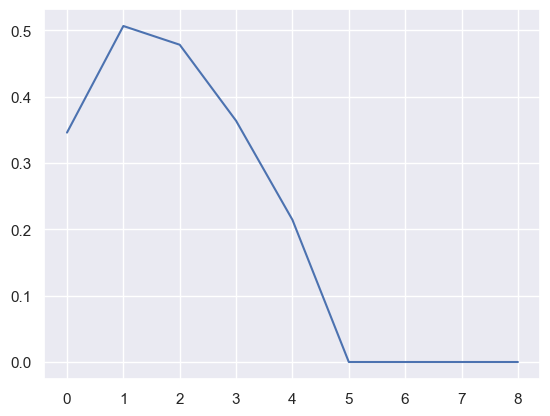

In [297]:
plt.plot(
    cross1.index,
    cross1.suv_rate,
)

In [301]:
cross1 = pd.crosstab(test.SibSp,test.Survived)
cross1['suv_rate'] = cross1[1]/cross1.sum(axis=1)
cross1

Survived,0,1,suv_rate
SibSp,,,
0,297,157,0.345815
1,118,96,0.448598


In [302]:
cross2 = pd.crosstab(data.Parch,data.Survived)
cross2['suv_rate'] = cross2[1]/cross2.sum(axis=1)
cross2

Survived,0,1,suv_rate
Parch,,,
0,338,174,0.339844
1,38,47,0.552941
2,32,29,0.475410
3,0,3,1.000000
4,3,0,0.000000
5,3,0,0.000000
6,1,0,0.000000


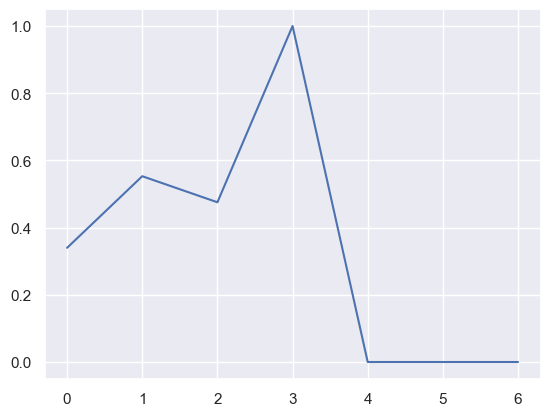

In [300]:
plt.plot(
    cross2.index,
    cross2.suv_rate,
)

In [294]:
cross2 = pd.crosstab(test.Parch,test.Survived)
cross2['suv_rate'] = cross2[1]/cross2.sum(axis=1)
cross2

Survived,0,1,suv_rate
Parch,,,
0,338,174,0.339844
1,77,79,0.506410


兄弟・家族は多すぎても良くない、とも解釈できるし、
いないよりはいた方が生存率は上がりそう（救助の優先度が上がる？）  
2値にするのはちょっとやり過ぎ感？そのまま使う

年齢は生存に関わると考えられるため、欠損値補完をして使用する。  
ある程度層化して平均を取りたい。  
分布を確認  

<Axes: xlabel='Pclass', ylabel='Age'>

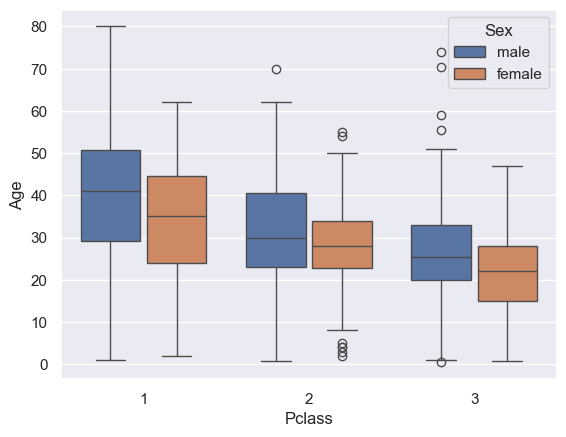

In [303]:
sns.boxplot(
    data=data,
    x='Pclass',
    y='Age',
    hue='Sex',
    gap=.1,
)

PclassとSexごとの平均値を使って補完する

#### Fareについて

<Axes: xlabel='Pclass', ylabel='Fare'>

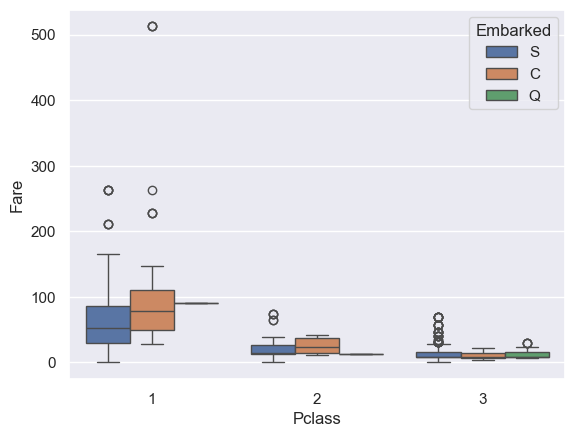

In [305]:
sns.boxplot(
    data=data,
    y='Fare',
    x='Pclass',
    hue='Embarked',
)

<Axes: xlabel='Pclass', ylabel='Fare'>

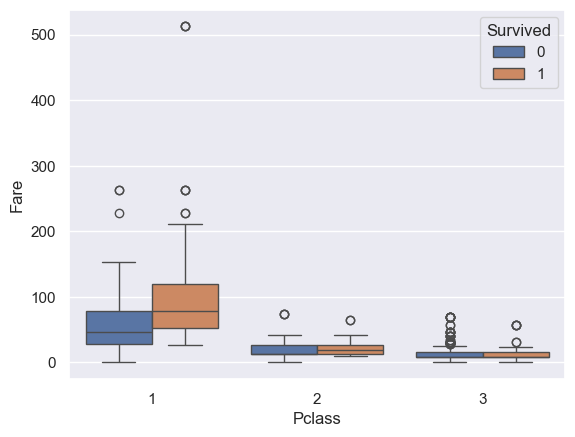

In [306]:
sns.boxplot(
    data=data,
    y='Fare',
    x='Pclass',
    hue='Survived',
)

pclass=1の中でも序列があって、fareはそれを表すっぽいかも。採用する

#### Embarked

In [307]:
data[['Survived','Embarked']].groupby('Embarked').sum() / data[['Survived','Embarked']].groupby('Embarked').count()

,Survived
Embarked,
C,0.555556
Q,0.362069
S,0.336049


In [308]:
data.groupby(['Embarked']).count()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Survived
Embarked,,,,,,,,,,
C,117,117,117,91,117,117,117,117,44,117
Q,58,58,58,21,58,58,58,58,3,58
S,491,491,491,422,491,491,491,491,100,491


訓練データ内だとCから乗った人の生存率が高く出ているが、なんか擬似相関っぽい  
とはいえ、明確に相関がある他の特徴量がなく、異なる特徴（例えば土地柄、とか？）を表す可能性は捨てきれないので、カテゴリカルとして使用する。

### ここまでのまとめ

特徴量

- Pclass ダミー変数化
- Sex ダミー変数化
- Age PclassとSexで層化平均補正
- SibSp ２値変換
- Parch ２値変換
- Fare
- Embarked ダミー変数化

In [316]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pclass    668 non-null    object
 1   Name      668 non-null    object
 2   Sex       668 non-null    object
 3   Age       536 non-null    object
 4   SibSp     668 non-null    object
 5   Parch     668 non-null    object
 6   Ticket    668 non-null    object
 7   Fare      668 non-null    object
 8   Cabin     149 non-null    object
 9   Embarked  666 non-null    object
 10  Survived  668 non-null    int64 
dtypes: int64(1), object(10)
memory usage: 57.5+ KB


In [341]:
# 年齢補完
avg_age = data.loc[~data.Age.isna()].groupby(['Pclass','Sex']).Age.mean()
avg_age = avg_age.reset_index().rename(columns={'Age':'Avg_age'})
data_ = pd.merge(
    left=data,
    right=avg_age,
    on=['Pclass','Sex'],
    how='left'
)
data_['Age'] = data_.Age.astype(float).fillna(data_.Avg_age.astype(float))
data_[data_.Age.isna()].head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Avg_age


In [342]:
# Embarkedは最頻値で補完
data_['Embarked']=data_['Embarked'].fillna(data_['Embarked'].mode()[0])

In [343]:
accept = [
    'Survived',
    'Pclass',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Embarked',
]
cleaned_data = data_[accept].copy()

In [344]:
cleaned_data['SibSp'] = cleaned_data.SibSp.astype(float)
cleaned_data['Parch'] = cleaned_data.Parch.astype(float)
cleaned_data['Fare'] = cleaned_data.Fare.astype(float)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  668 non-null    int64  
 1   Pclass    668 non-null    object 
 2   Sex       668 non-null    object 
 3   Age       668 non-null    float64
 4   SibSp     668 non-null    float64
 5   Parch     668 non-null    float64
 6   Fare      668 non-null    float64
 7   Embarked  668 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 41.9+ KB


In [345]:
fix_data = pd.get_dummies(cleaned_data,drop_first=True).astype(float)
fix_data.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,1.0,40.770286,0.0,0.0,30.5000,0.0,0.0,1.0,0.0,1.0
1,0.0,25.000000,0.0,0.0,7.0500,0.0,1.0,1.0,0.0,1.0
2,1.0,24.000000,0.0,2.0,14.5000,1.0,0.0,0.0,0.0,1.0
3,0.0,22.000000,0.0,0.0,7.5208,0.0,1.0,1.0,0.0,1.0
4,1.0,0.920000,1.0,2.0,151.5500,0.0,0.0,1.0,0.0,1.0


### モデリング

In [370]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

In [426]:
feature_names = fix_data.columns[1:]

In [356]:
X_trainval_treated = np.array(fix_data.loc[:,'Age':])
y_trainval_treated = np.array(fix_data['Survived'])

In [374]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval_treated,
    y_trainval_treated,
    random_state=42,
    )

In [380]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

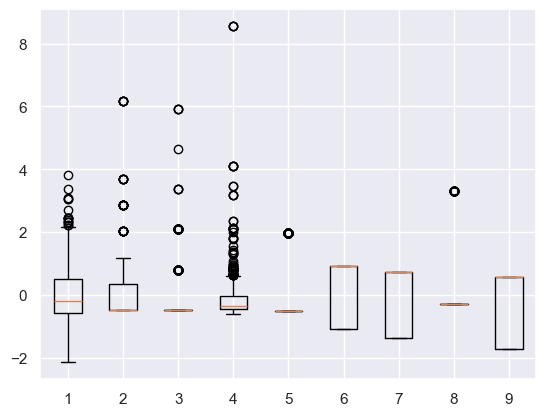

In [376]:
plt.boxplot(X_train_scaled)
plt.show()

In [381]:
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly =poly.transform(X_train_scaled)
X_valid_poly =poly.transform(X_valid_scaled)

In [382]:
print(f'origin : {X_train_scaled.shape}')
print(f'poly   : {X_train_poly.shape}')

origin : (501, 9)
poly   : (501, 55)


In [384]:
y_valid.shape

(167,)

In [437]:
logreg = LogisticRegression().fit(X_train_poly,y_train)
print('poly_L2')
print(f'train_acc : {logreg.score(X_train_poly,y_train):.3f}')
print(f'valid_acc : {logreg.score(X_valid_poly,y_valid):.3f}')
print(f'valid_auc : {roc_auc_score(y_valid, logreg.predict_proba(X_valid_poly)[:,1]):.3f}')


poly_L2
train_acc : 0.836
valid_acc : 0.808
valid_auc : 0.897


In [396]:
logreg = LogisticRegression(max_iter=2000).fit(X_train,y_train)
print('origin')
print(f'train_acc : {logreg.score(X_train,y_train):.3f}')
print(f'valid_acc : {logreg.score(X_valid,y_valid):.3f}')
print(f'valid_auc : {roc_auc_score(y_valid, logreg.predict_proba(X_valid)[:,1]):.3f}')



origin
train_acc : 0.812
valid_acc : 0.832
valid_auc : 0.866


In [438]:
logreg = LogisticRegression(penalty='l1',solver='liblinear').fit(X_train_poly,y_train)
print('poly_L1')
print(f'train_acc : {logreg.score(X_train_poly,y_train):.3f}')
print(f'valid_acc : {logreg.score(X_valid_poly,y_valid):.3f}')
print(f'valid_auc : {roc_auc_score(y_valid, logreg.predict_proba(X_valid_poly)[:,1]):.3f}')


poly_L1
train_acc : 0.836
valid_acc : 0.814
valid_auc : 0.891


In [428]:
poly.get_feature_names_out(input_features=feature_names).reshape(1,-1)

array([['1', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3',
        'Sex_male', 'Embarked_Q', 'Embarked_S', 'Age^2', 'Age SibSp',
        'Age Parch', 'Age Fare', 'Age Pclass_2', 'Age Pclass_3',
        'Age Sex_male', 'Age Embarked_Q', 'Age Embarked_S', 'SibSp^2',
        'SibSp Parch', 'SibSp Fare', 'SibSp Pclass_2', 'SibSp Pclass_3',
        'SibSp Sex_male', 'SibSp Embarked_Q', 'SibSp Embarked_S',
        'Parch^2', 'Parch Fare', 'Parch Pclass_2', 'Parch Pclass_3',
        'Parch Sex_male', 'Parch Embarked_Q', 'Parch Embarked_S',
        'Fare^2', 'Fare Pclass_2', 'Fare Pclass_3', 'Fare Sex_male',
        'Fare Embarked_Q', 'Fare Embarked_S', 'Pclass_2^2',
        'Pclass_2 Pclass_3', 'Pclass_2 Sex_male', 'Pclass_2 Embarked_Q',
        'Pclass_2 Embarked_S', 'Pclass_3^2', 'Pclass_3 Sex_male',
        'Pclass_3 Embarked_Q', 'Pclass_3 Embarked_S', 'Sex_male^2',
        'Sex_male Embarked_Q', 'Sex_male Embarked_S', 'Embarked_Q^2',
        'Embarked_Q Embarked_S', 'Embarked_S

In [408]:
logreg.coef_[0].shape

(55,)

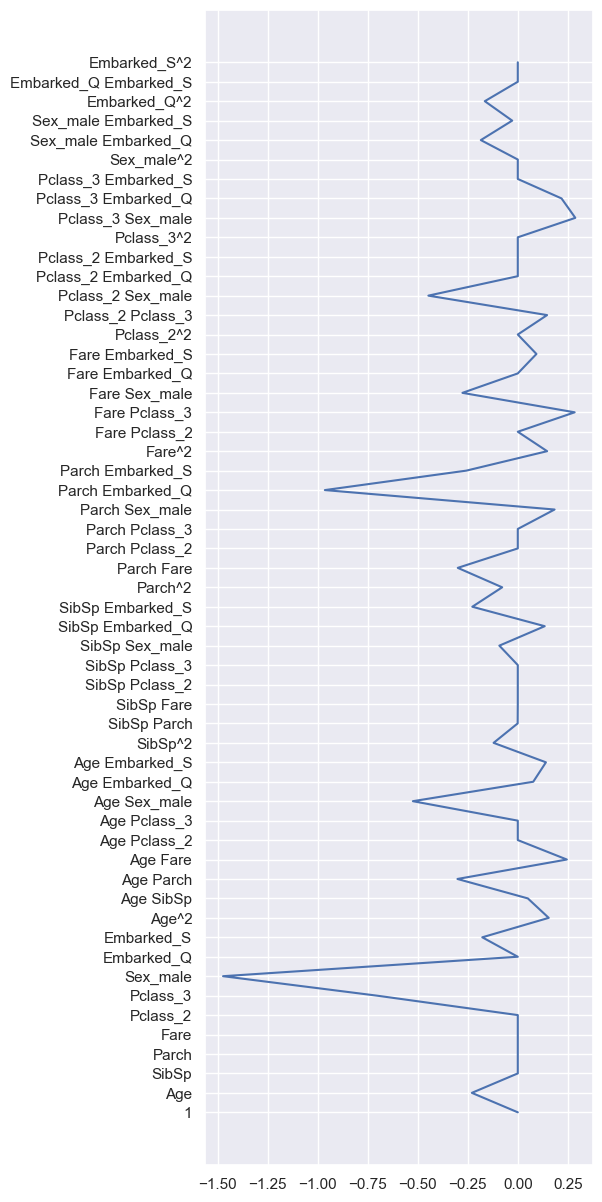

In [435]:
plt.figure(figsize=(5,15))
plt.plot(
    logreg.coef_[0],
    poly.get_feature_names_out(input_features=feature_names),
    )
# plt.xticks(rotation=90)
plt.show()

In [436]:
accepted_features = poly.get_feature_names_out(
    input_features=feature_names
    )[np.abs(logreg.coef_[0])!=0]

for n in accepted_features:
    print(n)

Age
Pclass_3
Sex_male
Embarked_S
Age^2
Age SibSp
Age Parch
Age Fare
Age Sex_male
Age Embarked_Q
Age Embarked_S
SibSp^2
SibSp Parch
SibSp Sex_male
SibSp Embarked_Q
SibSp Embarked_S
Parch^2
Parch Fare
Parch Sex_male
Parch Embarked_Q
Parch Embarked_S
Fare^2
Fare Pclass_3
Fare Sex_male
Fare Embarked_S
Pclass_2 Pclass_3
Pclass_2 Sex_male
Pclass_3 Sex_male
Pclass_3 Embarked_Q
Sex_male Embarked_Q
Sex_male Embarked_S
Embarked_Q^2


In [421]:
feature_names

['Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [388]:
logreg.predict_proba(X_train_poly)[:,1]

array([9.09022774e-02, 1.42642165e-01, 2.82122761e-01, 2.50469607e-01,
       2.29986850e-01, 1.34305273e-01, 9.74672470e-01, 9.92116946e-01,
       4.20794905e-02, 1.16122663e-01, 1.99897656e-01, 2.87977266e-01,
       1.01097306e-01, 9.44211375e-01, 4.38533705e-01, 1.26802790e-01,
       6.53773435e-01, 1.24424217e-01, 9.68112532e-01, 1.33898525e-01,
       1.70111987e-01, 1.07167703e-01, 1.07268438e-01, 9.33746514e-02,
       3.02974510e-01, 9.72056434e-01, 9.63154601e-01, 1.33602643e-01,
       1.21194160e-01, 9.84149519e-02, 9.69855943e-01, 3.60774150e-01,
       4.46586012e-01, 2.00541207e-01, 1.24101172e-01, 2.20231779e-01,
       2.94586021e-01, 1.32532944e-01, 1.34305273e-01, 1.61232798e-01,
       9.72963124e-01, 9.83054876e-01, 3.29230768e-01, 1.06698244e-01,
       1.53402061e-01, 1.02109432e-01, 8.58739022e-01, 1.01971741e-01,
       1.17135401e-01, 1.14729888e-01, 6.43588223e-02, 1.24101172e-01,
       1.65171794e-01, 7.29934010e-01, 9.74275898e-01, 3.02178632e-01,
      

In [387]:
logreg.predict(X_train_poly)

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1.